# U-Net by Lukas

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import layers, metrics

In [2]:
#image dimensions, seems to work with non-square inputs
IMAGE_CHANNELS = 3

IMAGE_HEIGHT =  192 #194 # 636 # 388 # 256
IMAGE_WIDTH = 64 # 70 # 229 # 140 # 128

In [3]:
seed = 4
np.random.seed = seed
random.seed(seed)
tf.random.set_seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"



train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]


X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

damaged = []
damaged_mask = []

# __author__ = "Sreenivas Bhattiprolu"
# __license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# # Credits https://github.com/bnsreenu/python_for_microscopists 

# """
# @author: Sreenivas Bhattiprolu
# """

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN # + id_

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  #Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0  
    mask = np.where(mask > 0.5, 1.0, 0.0) 

    y_train[n] = mask 
    if np.count_nonzero(mask) != 0:
        damaged.append(img)
        damaged_mask.append(mask)
    
# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = np.where(mask > 0.5, 1.0, 0.0) 
    
    test_masks[n] = mask 


## Data augmentation
vertical_train = np.flip(damaged, axis=0)
vertical_test = np.flip(damaged_mask, axis=0)

horizontal_train = np.flip(damaged, axis=1)
horizontal_test = np.flip(damaged_mask, axis=1)

rotating_train = np.rot90(damaged, k=2)
rotating_test = np.rot90(damaged_mask, k=2)

vert_rot_train = np.rot90(vertical_train, k=2)
vert_rot_test = np.rot90(vertical_test, k=2)

hor_rot_train = np.rot90(horizontal_train, k=2)
hor_rot_test = np.rot90(horizontal_test, k=2)

X_train = np.concatenate((vertical_train, horizontal_train, rotating_train, vert_rot_train, hor_rot_train, X_train))
y_train = np.concatenate((vertical_test, horizontal_test, rotating_test, vert_rot_test, hor_rot_test, y_train))

print('Done!')

Resizing training images and masks


100%|██████████| 2332/2332 [01:06<00:00, 35.18it/s]


Resizing test images


100%|██████████| 1004/1004 [00:31<00:00, 32.37it/s]


Done!


In [4]:
non_zero = np.count_nonzero(y_train)
print(non_zero)

unique, counts = np.unique(y_train, return_counts=True)

print(dict(zip(unique, counts)))
print("Percentage of faulty images in train data:", counts[1]/(counts[0]+counts[1])*100, " %")
neg = counts[0]
pos = counts[1]

490986
{0.0: 43340310, 1.0: 490986}
Percentage of faulty images in train data: 1.1201722166736754  %


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
print("x_train shape", X_train.shape)
print("x_val shape", X_val.shape)
print("y_train shape", y_train.shape)
print("y_val shape", y_val.shape)


x_train shape (2496, 192, 64, 3)
x_val shape (1071, 192, 64, 3)
y_train shape (2496, 192, 64)
y_val shape (1071, 192, 64)


In [6]:
def display(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(display_list[i], cmap='gray',  interpolation='nearest')
    elif i == 2:
      plt.imshow(display_list[i], cmap='jet',  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [7]:
index = 0
print([i for i in range(len(y_train)) if y_train[i].any()])

[0, 4, 6, 7, 9, 10, 13, 14, 16, 18, 20, 21, 25, 26, 27, 29, 30, 32, 36, 37, 38, 42, 43, 44, 51, 52, 56, 60, 64, 75, 76, 82, 83, 84, 90, 91, 101, 102, 106, 109, 112, 113, 116, 118, 119, 120, 121, 122, 123, 127, 128, 130, 136, 137, 143, 146, 147, 148, 150, 151, 153, 158, 159, 165, 168, 174, 176, 177, 178, 179, 180, 183, 184, 185, 186, 188, 189, 190, 193, 196, 198, 205, 207, 209, 213, 215, 219, 220, 221, 222, 223, 226, 232, 233, 235, 239, 244, 245, 249, 251, 253, 254, 255, 260, 261, 263, 265, 270, 273, 275, 276, 277, 281, 283, 285, 292, 293, 298, 307, 308, 311, 312, 313, 314, 316, 317, 318, 323, 324, 325, 326, 327, 329, 332, 333, 334, 336, 337, 344, 347, 348, 352, 354, 356, 359, 364, 365, 367, 372, 374, 375, 376, 377, 381, 382, 384, 386, 387, 389, 390, 392, 393, 394, 396, 400, 401, 402, 403, 404, 407, 410, 412, 415, 416, 419, 420, 421, 425, 428, 433, 434, 436, 445, 446, 447, 452, 456, 458, 460, 461, 462, 464, 466, 468, 470, 473, 478, 481, 482, 483, 486, 487, 489, 493, 494, 495, 496, 497, 

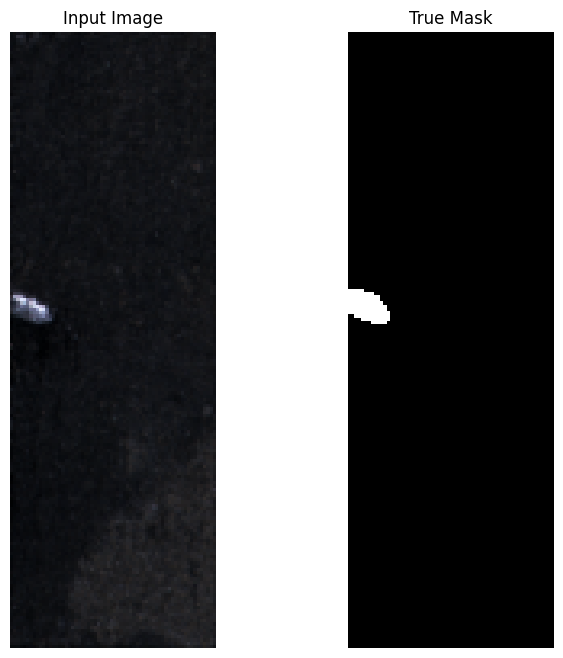

In [8]:
index = 0
example = y_train[index]
example = example.astype(np.uint)
display([X_train[index], example])

In [9]:
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [10]:
#Building U-net model
#Downward stream
inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
conv_11 = layers.Conv2D(32,kernel_size=(3,3), activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(inputs)
conv_12 = layers.Conv2D(32,kernel_size=(3,3), activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_11)#TODO: Understand parameters

max_pool_1 = layers.MaxPool2D((2,2))(conv_12)
conv_21 = layers.Conv2D(64,(3,3),activation = 'relu',padding= 'same',kernel_initializer = 'he_normal')(max_pool_1)
conv_22 = layers.Conv2D(64,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_21)

max_pool_2 = layers.MaxPool2D((2,2))(conv_22)
conv_31 = layers.Conv2D(128,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_2)
conv_32 = layers.Conv2D(128,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_31)

max_pool_3 = layers.MaxPool2D((2,2))(conv_32)
conv_41 = layers.Conv2D(256,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_3)
conv_42 = layers.Conv2D(256,(3,3),activation = 'relu', padding= 'same')(conv_41)

max_pool_4 = layers.MaxPool2D((2,2))(conv_42)
conv_51 = layers.Conv2D(512,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(max_pool_4)
conv_52 = layers.Conv2D(512,(3,3),activation = 'relu', padding= 'same',kernel_initializer = 'he_normal')(conv_51)

In [11]:
#Upward stream
upconv_1 = layers.Conv2DTranspose(256,(2,2), strides=(2,2))(conv_52)
upconv_1_conc = layers.concatenate([upconv_1,conv_42])
conv_61 = layers.Conv2D(256,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_1_conc)
conv_62 = layers.Conv2D(256,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_61)

upconv_2 = layers.Conv2DTranspose(128, (2,2), strides = (2,2))(conv_62)
upconv_2_conc = layers.concatenate([upconv_2, conv_32])
conv_71 = layers.Conv2D(128,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_2_conc)
conv_72 = layers.Conv2D(128,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_71)

upconv_3 = layers.Conv2DTranspose(64,(2,2), strides=(2,2))(conv_72)
upconv_3_conc = layers.concatenate([upconv_3,conv_22])
conv_81 = layers.Conv2D(64,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_3_conc)
conv_82 = layers.Conv2D(64,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_81)

upconv_4 = layers.Conv2DTranspose(32,(2,2), strides=(2,2))(conv_82)
upconv_4_conc = layers.concatenate([upconv_4,conv_12])
conv_91 = layers.Conv2D(32,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(upconv_4_conc)
conv_92 = layers.Conv2D(32,(3,3),activation = 'relu', padding = 'same',kernel_initializer = 'he_normal')(conv_91)
outputs = layers.Conv2D(1,(1,1), activation = 'sigmoid', padding = 'same',kernel_initializer = 'he_normal', bias_initializer=output_bias)(conv_92)#TODO: Check function here

In [12]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate = 0.0001)

In [13]:
#Compiling model
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy']) #TODO: Parameters check #metrics.BinaryIoU()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 192, 64, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 64, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 96, 32, 32)   0           ['conv2d_1[0][0]']           

                                                                                                  
 conv2d_2 (Conv2D)              (None, 96, 32, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)              (None, 96, 32, 64)   36928       ['conv2d_2[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 48, 16, 64)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 48, 16, 128)  73856       ['max_pooling2d_1[0][0]']        
                                                                                                  
 conv2d_5 (Conv2D)              (None, 48, 16, 128)  147584      ['conv2d_4[0][0]']               
          

In [14]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

In [15]:
epochs = 100  
batch_size = 15

history = model.fit(X_train, 
                    y_train, 
                    epochs = epochs, 
                    validation_data = (X_val, y_val), 
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[early_stopping]) 

Epoch 1/100
166/166 [==============================] - 17s 69ms/step - loss: 0.0461 - accuracy: 0.9899 - val_loss: 0.0309 - val_accuracy: 0.9906
Epoch 2/100
166/166 [==============================] - 9s 57ms/step - loss: 0.0284 - accuracy: 0.9915 - val_loss: 0.0256 - val_accuracy: 0.9911
Epoch 3/100
166/166 [==============================] - 9s 56ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0225 - val_accuracy: 0.9921
Epoch 4/100
166/166 [==============================] - 9s 57ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.0175 - val_accuracy: 0.9937
Epoch 5/100
166/166 [==============================] - 9s 56ms/step - loss: 0.0164 - accuracy: 0.9942 - val_loss: 0.0176 - val_accuracy: 0.9936
Epoch 6/100
166/166 [==============================] - 9s 57ms/step - loss: 0.0147 - accuracy: 0.9947 - val_loss: 0.0150 - val_accuracy: 0.9947
Epoch 7/100
166/166 [==============================] - 9s 57ms/step - loss: 0.0108 - accuracy: 0.9958 - val_loss: 0.0139 - val_accuracy

In [22]:
Y_pred = model.predict(test_images)

32/32 [==============================] - 1s 22ms/step


In [23]:
index = 0
index_test_damaged = [i for i in range(len(test_masks)) if test_masks[i].any()]

print(index_test_damaged)

[42, 56, 68, 84, 95, 99, 117, 118, 121, 125, 129, 130, 139, 141, 142, 155, 158, 159, 172, 175, 177, 190, 193, 204, 209, 217, 228, 231, 236, 246, 259, 264, 275, 281, 295, 297, 319, 334, 378, 392, 403, 416, 426, 428, 434, 439, 452, 457, 465, 486, 487, 502, 517, 523, 535, 543, 544, 546, 561, 564, 587, 599, 600, 624, 625, 632, 640, 646, 660, 665, 667, 669, 671, 672, 682, 685, 724, 738, 744, 747, 754, 765, 772, 784, 785, 801, 804, 816, 821, 827, 829, 834, 848, 857, 870, 881, 882, 884, 891, 892, 895, 902, 912, 922, 941, 942, 952, 956, 959, 969]


In [30]:
def save_fig(display_list, filename):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 1:
      plt.imshow(display_list[i], cmap='gray',  interpolation='nearest')
    elif i == 2:
      plt.imshow(display_list[i], cmap='jet',  interpolation='nearest')
    else:
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
#   plt.show()
  plt.savefig(filename)
  plt.close()

for index in index_test_damaged:
    filename = "predictedImages1/damaged_image_" + str(index) + ".png"
    save_fig([test_images[index], test_masks[index], Y_pred[index]], filename)

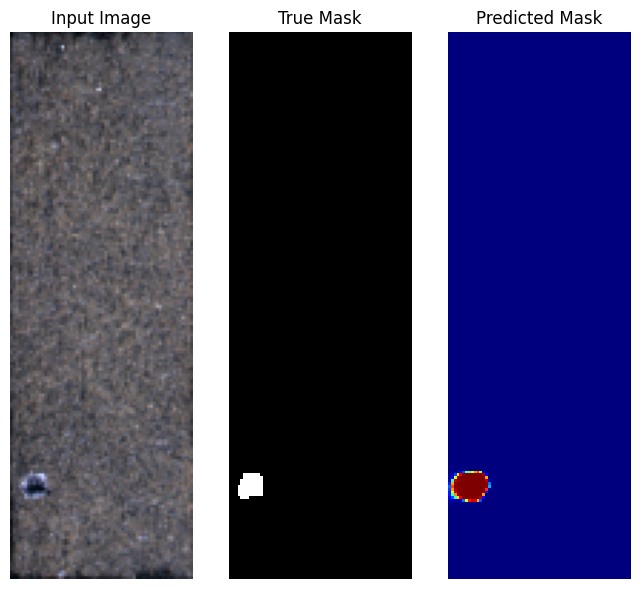

In [28]:
index = 177 #24
display([test_images[index], test_masks[index], Y_pred[index]])

In [20]:
# model.save("trainedModels/secondWorkingSegmentation.h5")

In [21]:
# Use scikit-learn to grid search the batch size and epochs
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(8,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# return model without compile
	return model


# # load dataset
# dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# # split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]

# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=15, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ModuleNotFoundError: No module named 'scikeras'